# OpenFoodFacts - Analysis of Packaging Data

__Goal__: Understand what packaging information is part of the product data and if it is ready to use for display in an app.

<div class="alert alert-block alert-info">
  <b>This notebook focuses on the top 1,000 German products in Open Food Facts with complete packaging information.</b>
</div>

__To be analyzed:__
  - the stored packaging information, i.e. packaging containers, covering, and material.
  - the completeness and consistency of packaging data (e.g. use of standard english taxonomy terms).
  - statistics about most frequent packaging container and materials.

__Summary (TL;TR)__
  - only a fraction (~0.9%) of German products are flagged as having complete packaging data.
  - those packaging details are still messy. For instance, some products
    - don't have any packaging data.
    - are missing the "shape" or "material" information in the packaging details.
    - are not properly annotated with the english taxonomy terms for "shape" and "material" but use other languages.
    - have generic "shape" annotations: `en:packaging`, `en:grouping-package`, `en:unknown`.
    - use annotations inconsistently, e.g. frozen pizza with "shape" `en:pizza-box` and `en:bag`|`en:wrapper`|`en:film`.
    - have very specific material annotations, like `xx:80-c-pap`, that are less suitable for average customers.
    - have non consolidated annotations, like `en:tetra-brik-aseptic`, `en:tetra-pak`, `en:tetra-brik`.

In [1]:
import pandas as pd
from urllib.request import urlopen, urlretrieve
from urllib.parse import urlencode
from pathlib import Path
import json

## Download Data from OpenFoodFacts API

___Only fetch the top 1,000 German products with complete packaging information!___

In [2]:
API_URL = "https://de.openfoodfacts.org/api/v2/search?"

PARAMS = {
    "page_size": 1000,
    "misc_tags": "packagings-complete",
    "fields": "code,brands,product_name,packagings,packagings_complete,packaging_tags"
}

DATA_FILE = "./off_de_complete_packagings_top1000.json"

# skip download if data has been downloaded before
if not Path(DATA_FILE).exists():
    urlretrieve(API_URL + urlencode(PARAMS), DATA_FILE)

# Exploratory Data Analysis

## Data Preparation

In [3]:
# load json file
with open(DATA_FILE) as f:
    data = json.load(f)

# create data frame from product information
prod_df = (pd.DataFrame(data['products'])
            .drop(['packagings_complete', 'packaging_tags'], axis=1)
            .set_index('code')
          )

computations = {
    # count number of packaging items
    "pack_num_items": lambda items: len(items),

    # check if packagings all have shapes
    "pack_all_shapes": lambda items: len(items) != 0 and all(['shape' in list for list in items]),

    # extract packaging shapes
    "pack_shape_list": lambda items: [i['shape'] if ('shape' in i) else None for i in items],

    # extract packaging materials
    "pack_material_list": lambda items: [i['material'] if ('material' in i) else None for i in items]
}

for key, fn in computations.items():
    prod_df[key] = prod_df.packagings.map(fn)

display(prod_df)

,brands,packagings,product_name,pack_num_items,pack_all_shapes,pack_shape_list,pack_material_list
code,,,,,,,
3274080005003,Cristaline,[{'material': 'en:pet-1-polyethylene-terephtha...,Eau de source,3,True,"[en:bottle, en:bottle-cap, en:label]","[en:pet-1-polyethylene-terephthalate, en:hdpe-..."
3017620422003,Ferrero,"[{'material': 'en:clear-glass', 'number_of_uni...",Nutella,5,True,"[en:pot, en:lid, en:backing, en:seal, en:label]","[en:clear-glass, en:pp-5-polypropylene, en:non..."
7622210449283,"Lu,Mondelez","[{'material': 'en:plastic', 'number_of_units':...",Prince Chocolat biscuits au blé complet,2,True,"[en:film, en:sleeve]","[en:plastic, en:cardboard]"
5449000214911,Coca cola,"[{'material': 'en:aluminium', 'number_of_units...",Coca-cola,1,True,[en:drink-can],[en:aluminium]
3017620425035,Ferrero,"[{'material': 'xx:82-c-pap', 'number_of_units'...",Nutella,5,True,"[en:seal, en:lid, en:jar, en:backing, en:label]","[xx:82-c-pap, en:pp-5-polypropylene, en:clear-..."
...,...,...,...,...,...,...,...
4337256172585,ja!,"[{'material': 'en:clear-glass', 'number_of_uni...",Creamy Cheese Dip,3,True,"[en:food-can, en:lid, en:label]","[en:clear-glass, en:plastic-aluminium, en:paper]"
4061461482046,"mein veggie Tag, Aldi, Tofu Life","[{'material': 'en:non-corrugated-cardboard', '...",Vegane Bio Grillsteaks,2,True,"[en:brick, en:film]","[en:non-corrugated-cardboard, en:plastic]"
5000112648843,,"[{'material': 'en:aluminium', 'number_of_units...",Americano,1,True,[en:can],[en:aluminium]


## Basic Statistics

### Frequency of products that have 1..n packaging items

<div class="alert alert-block alert-danger">
  <b>There are products with 0 packing information which should not be the case with status "packagings_complete".</b>
</div>

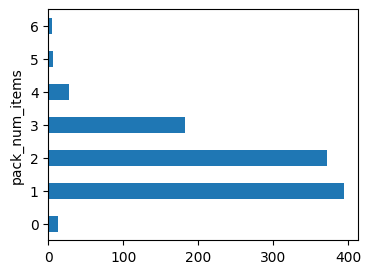

In [4]:
prod_df.pack_num_items.value_counts().sort_index().plot.barh(figsize=(4,3));

### Show items without packaging information

In [5]:
prod_df.loc[lambda df: df.pack_num_items == 0]

,brands,packagings,product_name,pack_num_items,pack_all_shapes,pack_shape_list,pack_material_list
code,,,,,,,
8710912064749,Valess,[],Vegetarische Schnitzel,0,False,[],[]
4061458007115,"Knusperone, H. & J. Brüggen, Aldi",[],Premium-Müsli - Früchte & Nüsse,0,False,[],[]
20793739,Natur Gut Penny,[],Bio fettarme H-Milch,0,False,[],[]
4260188785588,mymuesli,[],Blueberry,0,False,[],[]
7622210678041,Mondelez,[],Daim XXL,0,False,[],[]
4063367226069,K-Classic,[],Delikatess Feine Teewurst,0,False,[],[]
8600939212295,Stark,[],Prima peanuts,0,False,[],[]
3250392949228,Saint eloi,[],Mais BIO 285g,0,False,[],[]
5059319007649,"Kellogg's, Kellogg's - KELLOG Company",[],Miel pops loops,0,False,[],[]


### Items without proper "shape" data

<div class="alert alert-block alert-danger">
  <b>There are products missing packing information "shape" which should not be the case with status "packagings_complete".</b>
</div>

In [20]:
prod_df.pack_all_shapes.value_counts(normalize=True)

pack_all_shapes
True     0.936
False    0.064
Name: proportion, dtype: float64

In [7]:
prod_df.loc[lambda df: ~df.pack_all_shapes]

,brands,packagings,product_name,pack_num_items,pack_all_shapes,pack_shape_list,pack_material_list
code,,,,,,,
4008400401829,Ferrero,"[{'material': 'xx:82-c-pap'}, {'material': 'en...",Nutella,5,False,"[None, en:lid, en:seal, en:pot, None]","[xx:82-c-pap, en:pp-5-polypropylene, en:alumin..."
4011100001305,Mars,[{'material': 'en:plastic'}],M&M's,1,False,[None],[en:plastic]
20006105,Tastino,"[{'material': 'en:pp-5-polypropylene'}, {'mate...",Pan de centeno integral,2,False,"[None, en:fastener]","[en:pp-5-polypropylene, en:plastic]"
4056489232872,Belbake,[{'recycling': 'en:recycle'}],Cocoa powder,1,False,[None],[None]
8710912064749,Valess,[],Vegetarische Schnitzel,0,False,[],[]
...,...,...,...,...,...,...,...
4316268588843,BioBio,[{'material': 'en:plastic'}],Krusten Brötchen,1,False,[None],[en:plastic]
4061458012911,"Gut Bio, Willms Weißwasser, Aldi","[{'material': 'de:Kunststoff, Papier'}]",Bio-Hähnchen-Fleischwurst,1,False,[None],"[de:Kunststoff, Papier]"
4061458010917,Choceur,"[{'material': 'en:pp-5-polypropylene', 'number...",Kokos Schokolade,1,False,[None],[en:pp-5-polypropylene]


## Labels of Packaging Shapes

In [8]:
packagingShapes = [s for shapes in prod_df.pack_shape_list for s in shapes]
packagingShapesEn = [s for s in packagingShapes if s and s.startswith('en:')]
packagingShapesNonEn = [s for s in packagingShapes if s and not s.startswith('en:')]

### Most Frequent English Shape Terms

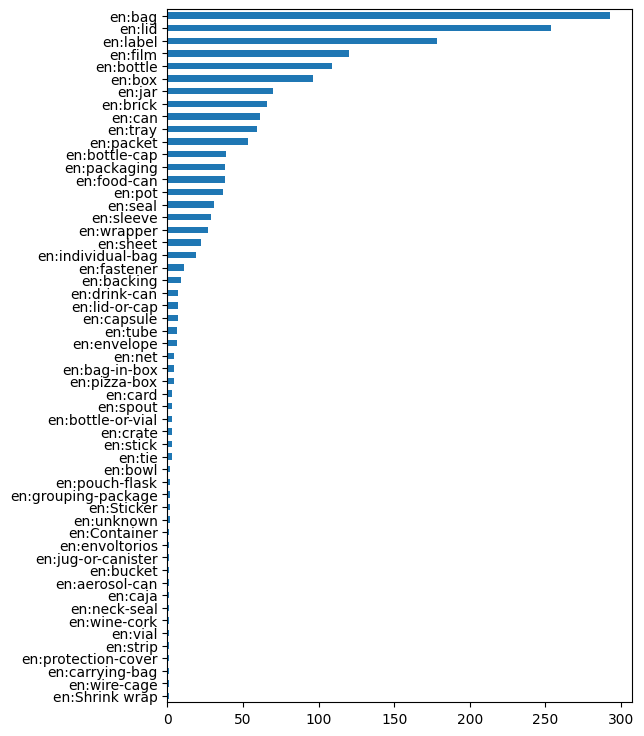

In [9]:
pd.Series(packagingShapesEn).value_counts(ascending=True).plot.barh(figsize=(6, 9));

### Most Frequent Non-English Shape Terms

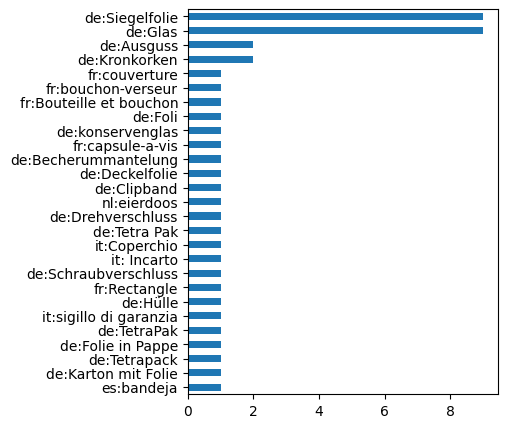

In [10]:
pd.Series(packagingShapesNonEn).value_counts(ascending=True).plot.barh(figsize=(4, 5));

### Investigate Products with specific package shape terms

- pizza-box
- brick
- tray

In [11]:
search = 'en:pizza-box'
prod_df.loc[lambda df: df.pack_shape_list.map(lambda shapes: search in shapes)]

,brands,packagings,product_name,pack_num_items,pack_all_shapes,pack_shape_list,pack_material_list
code,,,,,,,
4001724039297,Dr. Oetker Ristorante,"[{'material': 'en:cardboard', 'number_of_units...",Pizza Salame Mozzarella Pesto,2,True,"[en:pizza-box, en:bag]","[en:cardboard, en:plastic]"
4009233014002,"Wagner,Original Wagner,Fertigessen","[{'material': 'en:non-corrugated-cardboard', '...",Piccolinis Salami,1,True,[en:pizza-box],[en:non-corrugated-cardboard]
4250073457669,Followfood,"[{'material': 'en:plastic', 'number_of_units':...",Pizza Funghi mit Bio Dinkelboden,2,True,"[en:wrapper, en:pizza-box]","[en:plastic, en:paper]"
4056489095828,1001 Delights,"[{'material': 'en:paper', 'number_of_units': 1...",Steinofenpizza Döner-Art,2,True,"[en:pizza-box, en:film]","[en:paper, en:plastic]"


In [12]:
search = 'en:brick'
prod_df.loc[lambda df: df.pack_shape_list.map(lambda shapes: search in shapes)]

,brands,packagings,product_name,pack_num_items,pack_all_shapes,pack_shape_list,pack_material_list
code,,,,,,,
8076800195057,Barilla,"[{'material': 'en:non-corrugated-cardboard', '...",Spaghetti n.5,1,True,[en:brick],[en:non-corrugated-cardboard]
4056489346357,"Milbona,Vemondo,Lidl,envia","[{'material': 'en:cardboard', 'number_of_units...",Bio lait d'amande ENVIA LIDL,2,True,"[en:brick, en:bottle-cap]","[en:cardboard, en:plastic]"
5411188115472,Alpro,"[{'material': 'en:plastic', 'shape': 'en:bottl...",Soja riche en protéines,2,True,"[en:bottle-cap, en:brick]","[en:plastic, en:tetra-pak]"
4056489244691,"Vemondo, Lidl, Grønvang Food",[{'material': 'en:hdpe-2-high-density-polyethy...,Bio Hafer ohne Zuckerzusatz,3,True,"[en:lid, en:brick, de:Siegelfolie]","[en:hdpe-2-high-density-polyethylene, xx:84-c-..."
40264769,"Deli Reform, Walter Rau Lebensmittelwerke","[{'material': 'en:pp-5-polypropylene', 'number...",Deli Reform - Das Original,4,True,"[en:lid, en:label, en:brick, de:Siegelfolie]","[en:pp-5-polypropylene, en:paper, en:pp-5-poly..."
...,...,...,...,...,...,...,...
5411188511328,Alpro,"[{'material': 'en:tetra-pak', 'number_of_units...",Single Soya cream,2,True,"[en:brick, en:lid-or-cap]","[en:tetra-pak, en:plastic]"
7610200391186,"Valflora, Migros","[{'material': 'en:tetra-pak', 'number_of_units...",Demi-crème,1,True,[en:brick],[en:tetra-pak]
4063608500033,Velike,"[{'material': 'en:paperboard', 'number_of_unit...",Bio Hafer Drink mit Mandel,2,True,"[en:brick, en:lid]","[en:paperboard, en:plastic]"


In [13]:
search = 'en:tray'
prod_df.loc[lambda df: df.pack_shape_list.map(lambda shapes: search in shapes)].head(10)

,brands,packagings,product_name,pack_num_items,pack_all_shapes,pack_shape_list,pack_material_list
code,,,,,,,
7613035040823,"Nestlé,Nestlé Dessert","[{'material': 'en:aluminium', 'number_of_units...",Nestlé Dessert,5,True,"[en:sheet, en:sheet, en:film, en:tray, en:box]","[en:aluminium, en:paper, en:plastic, None, None]"
3504182920011,Azura,"[{'material': 'en:pet-transparent', 'number_of...",Tomates Gourmet,2,True,"[en:tray, en:film]","[en:pet-transparent, en:plastic]"
4000405005316,Rügenwalder Mühle,"[{'material': 'en:plastic', 'number_of_units':...",Vegane Mühlen Salami Klassisch,3,True,"[en:tray, en:film, en:label]","[en:plastic, en:plastic, en:paper]"
4017100370007,"Bahlsen,Leibniz","[{'material': 'en:pp-5-polypropylene', 'number...",Leibniz Butterkeks,2,True,"[en:wrapper, en:tray]","[en:pp-5-polypropylene, en:non-corrugated-card..."
7622300318116,Mondelēz,"[{'material': 'en:plastic-aluminium', 'shape':...",Philadelphia - Kräuter,3,True,"[en:tray, en:lid, en:film]","[en:plastic-aluminium, en:pp-5-polypropylene, ..."
4000405005002,"Rügenwalder Mühle,Rügenwalder, Rügenwalder Mühle","[{'material': 'en:pet-transparent', 'number_of...",Vegane Mühlen Schnitzel,2,True,"[en:tray, en:lid]","[en:pet-transparent, en:plastic]"
20435684,"Sondey, Lidl, Aachener Zucker- und Backwaren P...","[{'material': 'en:pp-5-polypropylene', 'number...",Bio Hafer-Cookies Vollmilchschokolade,2,True,"[en:bag, en:tray]","[en:pp-5-polypropylene, en:pet-transparent]"
20810405,"Chef select, Lidl, Heinrich Kühlmann",[{'material': 'en:pet-1-polyethylene-terephtha...,Hummus Pikant mit Chili verfeinert,3,True,"[en:tray, en:lid, de:Siegelfolie]","[en:pet-1-polyethylene-terephthalate, en:pet-1..."
3422440006638,Crealine,"[{'material': 'en:plastic', 'number_of_units':...",L'écrasé pommes de terre aux 2 carottes,3,True,"[en:tray, en:sleeve, en:seal]","[en:plastic, en:cardboard, en:plastic]"


In [14]:
search = 'de:Siegelfolie'
prod_df.loc[lambda df: df.pack_shape_list.map(lambda shapes: search in shapes)]

,brands,packagings,product_name,pack_num_items,pack_all_shapes,pack_shape_list,pack_material_list
code,,,,,,,
4056489244691,"Vemondo, Lidl, Grønvang Food",[{'material': 'en:hdpe-2-high-density-polyethy...,Bio Hafer ohne Zuckerzusatz,3,True,"[en:lid, en:brick, de:Siegelfolie]","[en:hdpe-2-high-density-polyethylene, xx:84-c-..."
40264769,"Deli Reform, Walter Rau Lebensmittelwerke","[{'material': 'en:pp-5-polypropylene', 'number...",Deli Reform - Das Original,4,True,"[en:lid, en:label, en:brick, de:Siegelfolie]","[en:pp-5-polypropylene, en:paper, en:pp-5-poly..."
20810405,"Chef select, Lidl, Heinrich Kühlmann",[{'material': 'en:pet-1-polyethylene-terephtha...,Hummus Pikant mit Chili verfeinert,3,True,"[en:tray, en:lid, de:Siegelfolie]","[en:pet-1-polyethylene-terephthalate, en:pet-1..."
20521493,Vitasia,"[{'material': 'en:clear-glass', 'number_of_uni...",Soja Soße,6,True,"[en:bottle, en:lid, de:Siegelfolie, en:label, ...","[en:clear-glass, en:pp-5-polypropylene, en:pla..."
8715700209159,Heinz,"[{'material': 'en:pet-transparent', 'number_of...",Mayonnaise Das Original,4,True,"[en:bottle, en:lid, de:Siegelfolie, en:label]","[en:pet-transparent, en:pp-5-polypropylene, No..."
4061458135115,"Wonnemeyer, ALDI, Heinrich Kühlmann","[{'material': 'en:pet-transparent', 'number_of...",Hummus - Ras El Hanout,4,True,"[en:tray, en:lid, de:Siegelfolie, en:label]","[en:pet-transparent, en:pet-transparent, en:pl..."
8719200237025,"Lätta,Upfield, Lätta, Lätta","[{'material': 'en:plastic', 'number_of_units':...",Lätta,3,True,"[en:tray, en:lid, de:Siegelfolie]","[en:plastic, en:plastic, en:aluminium]"
8690804682902,"Suntat, BLG Kardesler","[{'material': 'en:clear-glass', 'number_of_uni...",Tahin Sesampaste,4,True,"[en:jar, en:lid, de:Siegelfolie, en:label]","[en:clear-glass, en:plastic-tinplate, en:plast..."
4002674044959,Ostmann,"[{'material': 'en:pp-5-polypropylene', 'number...",Rosmarin gemahlen,4,True,"[en:can, en:lid, en:label, de:Siegelfolie]","[en:pp-5-polypropylene, en:plastic, en:plastic..."


In [15]:
search = 'de:Glas'
prod_df.loc[lambda df: df.pack_shape_list.map(lambda shapes: search in shapes)]

,brands,packagings,product_name,pack_num_items,pack_all_shapes,pack_shape_list,pack_material_list
code,,,,,,,
20072032,"Kania, Lidl, Haberland","[{'material': 'en:clear-glass', 'number_of_uni...",Delikatess Senf mittelscharf,3,True,"[de:Glas, en:label, en:lid]","[en:clear-glass, en:paper, en:ldpe-4-low-densi..."
8711200365524,Knorr,"[{'material': 'en:steel', 'number_of_units': 1...",Gemüse Bouillon,3,True,"[en:lid, de:Glas, en:label]","[en:steel, en:brown-glass, en:paper]"
4061458004251,"King's Crown, Sieben Schwaben, Aldi","[{'material': 'en:glass', 'number_of_units': 1...",Feinwürzige Gurken - süß-sauer,2,True,"[de:Glas, en:lid]","[en:glass, en:metal]"
4104060029066,Andechser Natur,"[{'material': 'en:glass', 'number_of_units': 1...",Joghurt mild - Mango,3,True,"[de:Glas, en:lid, en:label]","[en:glass, en:tin-plated-steel, en:paper]"
7640143671120,Ppura,"[{'material': 'en:glass', 'number_of_units': 1...",Pesto Genovese mit Pinienkernen (Bio),2,True,"[de:Glas, en:lid]","[en:glass, en:metal]"
4337185459504,K-Classic,"[{'material': 'en:pp-5-polypropylene', 'number...",Nussano Nuss-Nougat-Creme,2,True,"[en:lid, de:Glas]","[en:pp-5-polypropylene, en:glass]"
8032523530452,antichi sapori dell'Etna,"[{'material': 'en:glass', 'number_of_units': 1...","Pistazien Streich-Creme, italienisch",2,True,"[de:Glas, en:lid]","[en:glass, en:metal]"
4104420145702,Alnatura,"[{'material': 'en:clear-glass', 'number_of_uni...",Kokosöl,2,True,"[de:Glas, en:lid]","[en:clear-glass, de:Blech]"
4028286641164,NaN,"[{'number_of_units': 1, 'shape': 'de:Glas'}]",Rote Beete in Scheiben,1,True,[de:Glas],[None]


In [16]:
prod_df.iloc[59].packagings

[{'material': 'en:hdpe-2-high-density-polyethylene',
  'number_of_units': 1,
  'quantity_per_unit': '1',
  'recycling': 'en:discard',
  'shape': 'en:lid'},
 {'material': 'xx:84-c-pap',
  'number_of_units': 1,
  'quantity_per_unit': '1',
  'recycling': 'en:discard',
  'shape': 'en:brick'},
 {'number_of_units': 1, 'shape': 'de:Siegelfolie'}]

## Labels of Packaging Material

In [17]:
packagingMaterials = [s for mat in prod_df.pack_material_list for s in mat]
packagingMaterialsEn = [s for s in packagingMaterials if s and s.startswith('en:')]
packagingMaterialsNonEn = [s for s in packagingMaterials if s and not s.startswith('en:')]

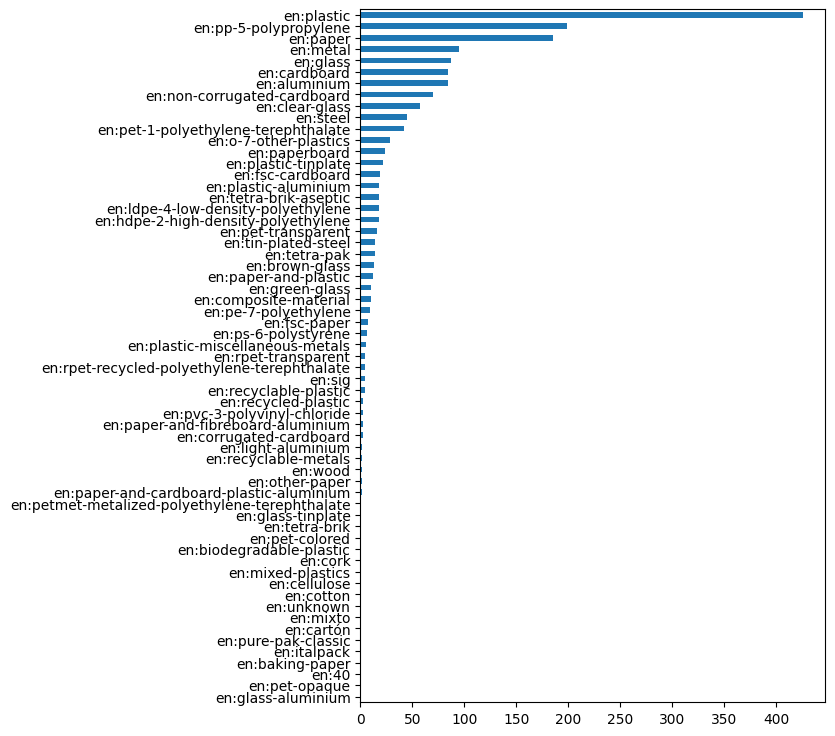

In [18]:
pd.Series(packagingMaterialsEn).value_counts(ascending=True).plot.barh(figsize=(6, 9));

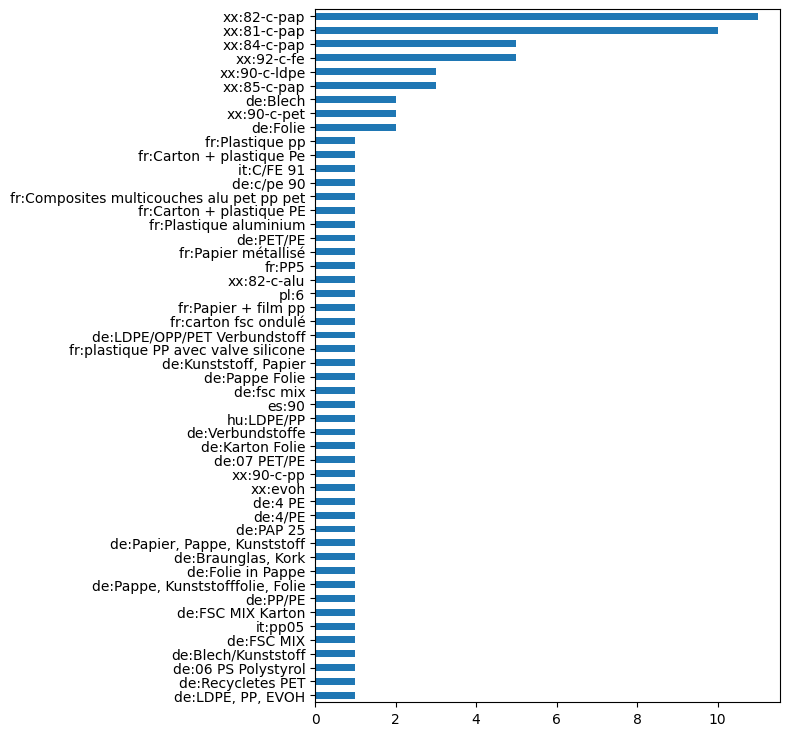

In [19]:
pd.Series(packagingMaterialsNonEn).value_counts(ascending=True).plot.barh(figsize=(6, 9));